/home/botian/miniconda3/envs/sim/lib/python3.7/site-packages/tqdm-4.64.1-py3.7.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[0.7644, 0.3751],
        [0.0751, 0.5308],
        [0.9660, 0.2770],
        [0.3372, 0.8910]])

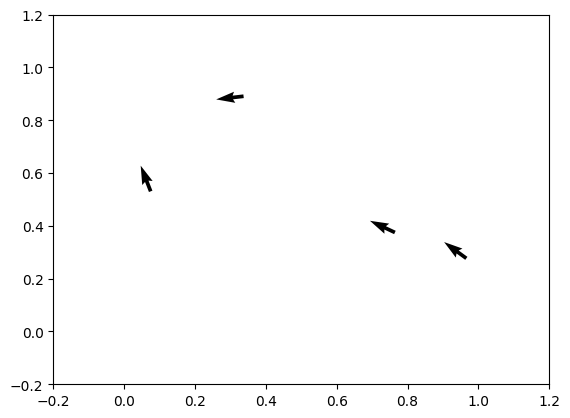

In [1]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(24)

pos = torch.rand(4, 2)
rot = torch.rand(4, 1) * torch.pi * 2
d = torch.cat([rot.cos(), rot.sin()], dim=-1)
x, y = pos.T
u, v = d.T

plt.quiver(x, y, u, v)
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)

pos

In [2]:
def separation(p0, p1, p1_d):
    rel_pos = rel_pos =  p1.unsqueeze(0) - p0.unsqueeze(1)
    z_distance = (rel_pos * p1_d).sum(-1, keepdim=True)
    z_displacement = z_distance * p1_d

    r_displacement = rel_pos - z_displacement
    r_distance = torch.norm(r_displacement, dim=-1, keepdim=True)
    return z_distance, r_distance
    
def downwash(p0, p1, p1_d, kr=2, kz=1):
    """
    p0: [n, d]
    p1: [m, d]
    p1: [m, d]
    """
    z, r = separation(p0, p1, p1_d)
    z = torch.clip(z, 0)
    v = torch.exp(-0.5 * torch.square(kr * r / z)) / (1 + kz * z)**2
    f = v * - p1_d
    return f

def off_diag(a: torch.Tensor) -> torch.Tensor:
    assert a.shape[0] == a.shape[1]
    n = a.shape[0]
    return a.flatten(0, 1)[1:].unflatten(0, (n-1, n+1))[:, :-1].reshape(n, n-1, *a.shape[2:])

f = downwash(pos, pos, d)
f.shape

torch.Size([4, 4, 2])

/home/botian/miniconda3/envs/sim/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor(0.8597)

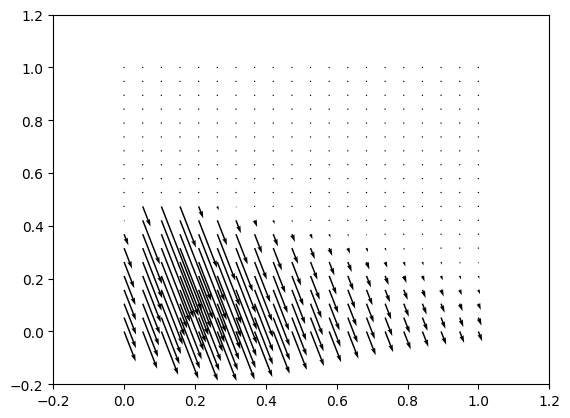

In [3]:
xx = torch.linspace(0, 1, 20)
to = torch.stack(torch.meshgrid(xx, xx), dim=-1).flatten(0, 1)
f = downwash(to, pos[[1]], d[[1]], kr=2).squeeze()

plt.quiver(*to.T, *f.T)
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
f.norm(dim=-1).max()

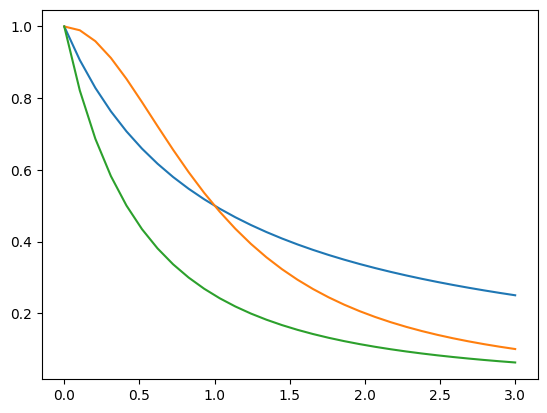

In [4]:
x = torch.linspace(0, 3, 30)
plt.plot(x, 1/(x+1))
plt.plot(x, 1/(x*x+1))
plt.plot(x, 1/(x+1)**2)